

<center>
<p><img height="60%" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Escudo/EscUpm.jpg" align="center" hspace="0px" vspace="0px"></p>
<h2><b>Artificial Neural Networks and Deep Learning - Universidad Politécnica de Madrid (UPM)</b></h2>
<h3>Deep Q-Learning for Lunar Lander</h3>
</center>

---------

<center>
<p>This notebook includes an implementation of the Deep Q-learning (DQN) algorithm for the cartpole problem (see <a src='https://www.gymlibrary.dev/environments/box2d/lunar_lander/'>Lunar Lander documentation</a>)</p>
</center>




<center><h1><b>Autor</b></h1></center>

<div style="overflow-x:auto;">
<table style="margin-left: auto; margin-right: auto;" border="0">
<tr>


<td style="text-align: center;">

**Víctor Salvador López**  
Email: victor.salvador@alumnos.upm.es

</td>

</tr>
</table>
</div>



<a class="anchor" id="01"></a>
# **Table of Contents**

1. [Libraries](#1)

2. [Hyperparameters](#2)

    2.1. [Hyperparameters Description](#31)

3. [Classes & Algorithms](#3)

    3.1. [ReplayMemmory Class](#31)

    3.2. [DQN Class](#32)
    
4. [Lunar Lander Model](#4)

    4.1. [Environment](#41)

    4.2. [Training lunar lander model](#42)

    4.3. [Lunar lander Train Results](#43)

    4.4. [Testing lunar lander model](#44)

    4.5. [Lunar lander Test Results](#45)

5. [Conclusions](#5)

# **1. Libraries** <a class="anchor" id="1"></a>

[Table of Contents](#01)

In [1]:
import matplotlib.pyplot as plt
from tensorflow import keras
import gymnasium as gym

import numpy as np
import platform
import random
import h5py
import time
import math

import wmi
import os


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from functools import partial

from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

# **2. Hyperparameters** <a class="anchor" id="2"></a>

[Table of Contents](#01)

### **2.1. Hyperparameters Description** <a class="anchor" id="21"></a>

[Table of Contents](#01)

In [2]:
# Factor de descuento para el cálculo del retorno futuro. Valores cercanos a 1 hacen que el agente valore más las recompensas futuras
GAMMA = 0.99

# Tamaño de la memoria de repetición. Determina cuántas transiciones pasadas guarda el agente para el aprendizaje
MEMORY_SIZE = 2000000

# Tasa de aprendizaje para el optimizador del modelo. Valores más bajos significan aprendizaje más lento pero más estable
LEARNING_RATE = 0.001

# Tamaño del lote utilizado para el aprendizaje. Un tamaño de lote mayor puede mejorar la estabilidad del aprendizaje
BATCH_SIZE = 32

# Valor máximo de exploración en la política epsilon-greedy. Inicialmente, el agente explora al máximo
EXPLORATION_MAX = 1

# Valor mínimo de exploración. A medida que avanza el aprendizaje, la exploración disminuye hasta este valor
EXPLORATION_MIN = 0.05

# Tasa de decaimiento de la exploración. Determina qué tan rápido disminuye la exploración a lo largo del tiempo
EXPLORATION_DECAY = 0.99995

# Número total de episodios para entrenar al agente. Un número mayor permite un aprendizaje más extenso 600
NUMBER_OF_EPISODES_FOR_TRAINING = 600

# Número de episodios utilizados para probar y evaluar el rendimiento del agente después del entrenamiento
NUMBER_OF_EPISODES_FOR_TESTING = 30

# Máximo de iteraciones en cada episodio para evitar bajadas extremadamente largas y por tanto entrenamientos más lentos
MAX_STEPS_PER_EPISODE = 5000  


# **3. Classes & Algorithms** <a class="anchor" id="3"></a>

[Table of Contents](#01)

In [3]:
from sklearn.cluster import KMeans

### **3.1. ReplayMemory Class** <a class="anchor" id="31"></a>

[Table of Contents](#01)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import KMedoids
from hdbscan import HDBSCAN, approximate_predict
from sklearn.cluster import Birch
from sklearn.preprocessing import StandardScaler
import warnings
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore", category=FutureWarning)

# INITIAL_CLUSTERING_THRESHOLD = 30000
INITIAL_CLUSTERING_THRESHOLD = 60000

class ReplayMemory:
    def __init__(self, number_of_observations, number_of_actions, n_clusters=300, algorithm='birch'):
        self.states = np.zeros((MEMORY_SIZE, number_of_observations))
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.q_values = np.zeros((MEMORY_SIZE, number_of_actions))
        self.rewards = np.zeros(MEMORY_SIZE)
        self.is_exploration = np.empty(MEMORY_SIZE, dtype=object)
        self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
        self.current_size = 0
        self.n_clusters = n_clusters
        self.algorithm = algorithm
        self.cluster_model = self.initialize_cluster_model(n_clusters)
        self.clusters_assigned = np.zeros(MEMORY_SIZE, dtype=int)
        self.scaler = StandardScaler()
        self.is_clustering_trained = False
        self.last_reward=None

        # Red neuronal auxiliar y métricas
        self.aux_model = self.create_aux_model(number_of_observations + number_of_actions)
        self.is_aux_model_trained = False
        self.train_losses = []
        self.train_rmse_scores = []
        self.val_losses = []
        self.val_rmse_scores = []
        self.used_train_indices = set()
        self.used_val_indices = set()

    def create_aux_model(self, input_size):
        model = keras.Sequential([
            layers.Dense(128, input_shape=(input_size,), activation="relu", kernel_regularizer=l2(0.01)),
            layers.BatchNormalization(),
            layers.Dense(64, activation="relu", kernel_regularizer=l2(0.01)),
            layers.BatchNormalization(),
            layers.Dense(32, activation="relu", kernel_regularizer=l2(0.01)),
            layers.Dense(1, activation="linear")
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse')
        return model
    
    

    def print_memory(self):
        print("Current Size of Memory:", self.current_size)
        print("\nStates:\n", self.states[:self.current_size])
        print("\nNext States:\n", self.states_next[:self.current_size])
        print("\nActions:\n", self.actions[:self.current_size])
        print("\nQ Values:\n", self.q_values[:self.current_size])
        print("\nRewards:\n", self.rewards[:self.current_size])
        print("\nTerminal States:\n", self.terminal_states[:self.current_size])
        print("\nCluster Assignments:\n", self.clusters_assigned[:self.current_size])

    def initialize_cluster_model(self, k):
        # Asignación de modelo basada en el algoritmo seleccionado
        if self.algorithm == 'kmeans':
            return KMeans(n_clusters=k)
        elif self.algorithm == 'dbscan':
            return DBSCAN()
        elif self.algorithm == 'hdbscan':
            return HDBSCAN(min_cluster_size=k, prediction_data=True)  # Enable prediction data
        elif self.algorithm == 'kmedoids':
            return KMedoids(n_clusters=k)
        elif self.algorithm == 'agglomerative':
            return AgglomerativeClustering(n_clusters=k)
        elif self.algorithm == 'gmm':
            return GaussianMixture(n_components=k)
        elif self.algorithm == 'birch':
            return Birch(n_clusters=k)
        else:
            raise ValueError(f"Unsupported clustering algorithm: {self.algorithm}")

    def store_transition(self, state, action, reward, state_next, terminal_state, is_exploration, q_values):
        index = self.current_size % MEMORY_SIZE
        self.states[index] = np.array(state).flatten()
        self.states_next[index] = np.array(state_next).flatten()
        self.actions[index] = action
        self.is_exploration[index]=is_exploration
        if is_exploration:
            self.q_values[index] = np.eye(self.q_values.shape[1])[action]
        else:
            self.q_values[index] = q_values
        self.rewards[index] = reward
        self.last_reward = reward
        self.terminal_states[index] = terminal_state
        self.current_size = (self.current_size + 1) % MEMORY_SIZE

        if self.is_clustering_trained:
            # Normalizar el estado antes de predecir el cluster
            normalized_state = self.normalize_state(self.states[index])
            
            if self.algorithm == 'hdbscan':
                self.clusters_assigned[index] = approximate_predict(self.cluster_model, [normalized_state])[0]
            elif self.algorithm == 'dbscan':
                self.clusters_assigned[index] = self.dbscan_predict(self.cluster_model, [normalized_state])
            elif hasattr(self.cluster_model, 'predict'):
                self.clusters_assigned[index] = self.cluster_model.predict([normalized_state])[0]
            elif self.algorithm == 'gmm':
                self.clusters_assigned[index] = self.cluster_model.predict([normalized_state])[0]
            elif self.algorithm == 'som':
                self.clusters_assigned[index] = self.som_predict(self.cluster_model, normalized_state)

        # Entrenar el clustering una vez alcanzado el umbral y si no ha sido entrenado antes
        elif self.current_size == INITIAL_CLUSTERING_THRESHOLD:
            self.train_clusters()
            normalized_states = self.normalize_states(self.states[:self.current_size])
            if self.algorithm == 'hdbscan':
                self.clusters_assigned[:self.current_size] = approximate_predict(self.cluster_model, normalized_states)[0]
            elif self.algorithm == 'dbscan':
                self.clusters_assigned[:self.current_size] = self.dbscan_predict(self.cluster_model, normalized_states)
            elif hasattr(self.cluster_model, 'predict'):
                self.clusters_assigned[:self.current_size] = self.cluster_model.predict(normalized_states)
            elif self.algorithm == 'gmm':
                self.clusters_assigned[:self.current_size] = self.cluster_model.predict(normalized_states)
            elif self.algorithm == 'som':
                for i in range(self.current_size):
                    self.clusters_assigned[i] = self.som_predict(self.cluster_model, normalized_states[i])
            self.is_clustering_trained = True

    def normalize_state(self, state):
        numeric_part = state[:6].reshape(1, -1)
        normalized_numeric_part = self.scaler.transform(numeric_part)
        return np.hstack((normalized_numeric_part, state[6:].reshape(1, -1)))[0]

    def normalize_states(self, states):
        numeric_part = states[:, :6]
        normalized_numeric_part = self.scaler.transform(numeric_part)
        return np.hstack((normalized_numeric_part, states[:, 6:]))

    def train_aux_model(self):
        if self.current_size < INITIAL_CLUSTERING_THRESHOLD:
            return
        print("Entrenando modelo auxiliar...")
        data_size = min(self.current_size, MEMORY_SIZE)
        indices = np.arange(data_size)
        np.random.shuffle(indices)
        train_size = int(data_size * 0.85)
        
        train_indices = indices[:train_size]
        val_indices = indices[train_size:]
        
        train_states = self.states[train_indices]
        train_q_values = self.q_values[train_indices]
        train_inputs = np.hstack((train_states, train_q_values))
        train_rewards = self.rewards[train_indices]

        val_states = self.states[val_indices]
        val_q_values = self.q_values[val_indices]
        val_inputs = np.hstack((val_states, val_q_values))
        val_rewards = self.rewards[val_indices]

        history = self.aux_model.fit(train_inputs, train_rewards, validation_data=(val_inputs, val_rewards), epochs=25, verbose=0)
        
        self.train_losses.extend(history.history['loss'])
        self.val_losses.extend(history.history['val_loss'])

        train_predictions = self.aux_model.predict(train_inputs, verbose=0)
        train_rmse = np.sqrt(mean_squared_error(train_rewards, train_predictions))
        self.train_rmse_scores.append(train_rmse)

        val_predictions = self.aux_model.predict(val_inputs, verbose=0)
        val_rmse = np.sqrt(mean_squared_error(val_rewards, val_predictions))
        self.val_rmse_scores.append(val_rmse)
        self.is_aux_model_trained=True

    def predict_reward(self, state, q_values):
        input_data = np.hstack((state, q_values))
        predicted_reward = self.aux_model.predict(input_data.reshape(1, -1), verbose=0)
        return predicted_reward[0][0]


    def predict_reward(self, state, q_values):
        input_data = np.hstack((state, q_values))
        predicted_reward = self.aux_model.predict(input_data.reshape(1, -1), verbose=0)
        return predicted_reward[0][0]

    def predict_reward(self, state, q_values):
        input_data = np.hstack((state, q_values))
        predicted_reward = self.aux_model.predict(input_data.reshape(1, -1), verbose=0)
        return predicted_reward[0][0]

    def plot_metrics(self):
        plt.figure(figsize=(12, 6))

        # Plot de la pérdida
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot del RMSE
        plt.subplot(1, 2, 2)
        plt.plot(self.train_rmse_scores, label='Training RMSE')
        plt.plot(self.val_rmse_scores, label='Validation RMSE')
        plt.title('RMSE Scores')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def train_clusters(self):
        print("Attempting to train clusters...")  # Debug: Confirmar la llamada al método
        if self.current_size < INITIAL_CLUSTERING_THRESHOLD:
            print(f"Not enough data to train. Current size: {self.current_size}")  # Debug: Razón del retorno temprano
            return  # Insufficient data to perform clustering

        X_numeric = self.states[:self.current_size, :6]
        X_normalized = self.scaler.fit_transform(X_numeric)
        X = np.hstack((X_normalized, self.states[:self.current_size, 6:]))

        if self.algorithm != 'som':
            if self.algorithm == 'gmm':
                self.cluster_model.fit(X)
                self.clusters_assigned[:self.current_size] = self.cluster_model.predict(X)
            else:
                self.clusters_assigned[:self.current_size] = self.cluster_model.fit_predict(X)
        else:
            self.train_som(X)

        self.is_clustering_trained = True

    def sample_memory(self, batch_size):
        max_mem = min(self.current_size, MEMORY_SIZE)
        batch = np.random.choice(max_mem, batch_size, replace=False)
        states = self.states[batch]
        states_next = self.states_next[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]
        terminal_states = self.terminal_states[batch]
        q_values = self.q_values[batch]
        return states, actions, rewards, states_next, terminal_states, q_values

    def filter_transitions_by_cluster(self, cluster_id):
        indices = np.where(self.clusters_assigned[:self.current_size] == cluster_id)[0]
        return {
            'states': self.states[indices],
            'actions': self.actions[indices],
            'rewards': self.rewards[indices],
            'states_next': self.states_next[indices],
            'terminal_states': self.terminal_states[indices],
            'q_values' : self.q_values[indices]
        }
    
    def predict_clusters(self, states):
        if self.algorithm == 'hdbscan':
            return approximate_predict(self.cluster_model, states)[0]
        elif self.algorithm == 'dbscan':
            return self.dbscan_predict(self.cluster_model, states)
        elif hasattr(self.cluster_model, 'predict'):
            return self.cluster_model.predict(states)
        elif self.algorithm == 'gmm':
            return self.cluster_model.predict(states)
        elif self.algorithm == 'som':
            return [self.som_predict(self.cluster_model, state) for state in states]


    def predict_cluster(self, state):
        if self.algorithm == 'hdbscan':
            return approximate_predict(self.cluster_model, [state])[0]
        elif self.algorithm == 'dbscan':
            return self.dbscan_predict(self.cluster_model, [state])
        elif hasattr(self.cluster_model, 'predict'):
            return self.cluster_model.predict([state])[0]
        elif self.algorithm == 'gmm':
            return self.cluster_model.predict([state])[0]
        elif self.algorithm == 'som':
            return self.som_predict(self.cluster_model, state)


### **3.2. DQN Class** <a class="anchor" id="32"></a>

[Table of Contents](#01)

In [5]:
class DQN:
    def __init__(self, number_of_observations, number_of_actions):
        self.exploration_rate = EXPLORATION_MAX
        self.losses = []  # Lista para almacenar las pérdidas
        self.exploration_rates = []  # Lista para almacenar las tasas de exploración
        self.number_of_actions = number_of_actions
        # Aumentar el número de observaciones para incluir el estado adicional
        self.number_of_observations = number_of_observations + 1
        self.scores = []
        self.memory = ReplayMemory(self.number_of_observations, self.number_of_actions)
        self.model = keras.Sequential([
            keras.layers.Dense(128, input_shape=(self.number_of_observations,), activation="relu", kernel_initializer="he_normal"),
            keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
            keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal"),
            keras.layers.Dense(number_of_actions, activation="linear")
        ])
        self.temporal_qvalues = None
        self.model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

    def remember(self, state, action, reward, next_state, terminal_state, is_exploration):
        q_values = self.temporal_qvalues
        self.last_reward=reward
        self.memory.store_transition(state, action, reward, next_state, terminal_state, is_exploration, q_values)

    def select(self, state):
        if np.random.rand() < self.exploration_rate:
            choice = np.random.randint(self.number_of_actions)
            self.temporal_qvalues = np.eye(self.number_of_actions)[choice]
            return choice, True
        else:
            if self.memory.is_clustering_trained and self.memory.is_aux_model_trained and np.random.rand() < 0.15:
                # Realizar intensificación bayesiana
                try:
                    return self.select_with_bayesian_intensification(state)
                except Exception as e:
                    print(e)
                    q_values = self.model.predict(state.reshape(1, -1), verbose=0)[0]
                    self.temporal_qvalues = q_values
                    return np.argmax(q_values), "DQN"

            else:
                # Realizar intensificación clásica
                q_values = self.model.predict(state.reshape(1, -1), verbose=0)[0]
                self.temporal_qvalues = q_values
                return np.argmax(q_values), "DQN"

    def select_greedy_policy(self, state):
        state = np.array(state).reshape((1, self.number_of_observations))
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def learn(self):
        if self.memory.current_size < BATCH_SIZE:
            return

        states, actions, rewards, next_states, terminal_states, q_values = self.memory.sample_memory(BATCH_SIZE)

        q_targets = self.model.predict(states, verbose=0)
        q_next_states = self.model.predict(next_states, verbose=0)

        for i in range(BATCH_SIZE):
            if terminal_states[i]:
                q_targets[i, actions[i]] = rewards[i]
            else:
                q_targets[i, actions[i]] = rewards[i] + GAMMA * np.max(q_next_states[i])

        loss = self.model.train_on_batch(states, q_targets)
        self.losses.append(loss)

        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def add_score(self, score):
        self.scores.append(score)

    def delete_scores(self):
        self.scores = []

    def display_scores_graphically(self):
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")
        plt.show()

    def load_model(self, model_path):
        self.model = keras.models.load_model(model_path)

    def add_exploration_rate(self):
        self.exploration_rates.append(self.exploration_rate)



    def cost_wrapper_eda(self, q_values, state, filter_sample):
        global muestra, ind
        actions_names = ["Nada", "Motor izquierdo", "Motor principal", "Motor derecho"]
        solution_dict = {name: value for name, value in zip(actions_names, q_values)}
        last_reward = self.last_reward
        if muestra:
            reward = filter_sample["rewards"][ind]
            inc_reward = reward - last_reward
            ind += 1
            if ind <= len(filter_sample["rewards"]):
                muestra = False
            return -reward
        else:
            reward_predicted = self.memory.predict_reward(state, q_values)
            inc_reward = reward_predicted - last_reward
            return -inc_reward

    def filtrar_top_30(self, filter_sample):
        rewards = filter_sample["rewards"]
        q_values = filter_sample["q_values"]

        # Ordena los índices según las recompensas en orden descendente
        indices_sorted = sorted(range(len(rewards)), key=lambda i: rewards[i], reverse=True)
        top_30 = min(len(indices_sorted), 30)  # Toma los primeros 30 o menos si hay menos de 30 valores

        # Filtrar los top 30 de rewards y q_values
        top_rewards = [rewards[i] for i in indices_sorted[:top_30]]
        top_q_values = [q_values[i] for i in indices_sorted[:top_30]]

        # Crear un nuevo filter_sample solo con el top 30
        new_filter_sample = {
            "rewards": top_rewards,
            "q_values": top_q_values
        }
        return new_filter_sample



    def genetic_intensification(self, state):
        # Predecir el cluster al que pertenece el nuevo estado
        cluster_predicted = self.memory.predict_cluster(state)

        # Filtrar las transiciones por el cluster predicho
        filter_sample = self.memory.filter_transitions_by_cluster(cluster_predicted)

        # Filtra y ordena las transiciones para obtener el top 20% de recompensas
        filter_sample = self.filtrar_top_20_percent(filter_sample)
        print("filtrado")

        # Inicializar speda con las transiciones filtradas
        from EDAspy2.optimization import EGNA
        from EDAspy2.optimization import SPEDA
        size_gen = 30

        if len(filter_sample["q_values"]) < size_gen:
            size_gen = len(filter_sample["q_values"])

        eda = EGNA(
            size_gen=size_gen,
            max_iter=4,
            dead_iter=2,
            n_variables=4,
            alpha=0.5,
            # l=4, # param l: SPEDA is an archive-base approach. Thus, in each generation updates the probabilistic model with the best solutions of the previous l generations.
            lower_bound=self.memory.q_values.min(),
            upper_bound=self.memory.q_values.max(),
            init_data=np.array(filter_sample["q_values"]),
            disp=False
        )
        
        def reiniciar_variables():
            global muestra, ind
            muestra = True
            ind = 0

        reiniciar_variables()

        cost_function = partial(self.cost_wrapper_eda, state=state, filter_sample=filter_sample)
        resultado_eda=eda.minimize(cost_function).best_ind
        print(resultado_eda)
        # return eda.minimize(cost_function).best_ind[0]
        return eda.minimize(cost_function).best_ind

    def select_with_bayesian_intensification(self, state):
        q_values_bayesian = self.genetic_intensification(state)
        self.temporal_qvalues = q_values_bayesian
        return np.argmax(q_values_bayesian), "EDA"


    def predict_cluster(self, state):
        normalized_state = self.memory.normalize_state(state)
        return self.memory.predict_cluster(normalized_state)


# **4. Lunar Lander Model** <a class="anchor" id="4"></a>

[Table of Contents](#01)

### **4.1. Environment** <a class="anchor" id="31"></a>

[Table of Contents](#01)

In [6]:
def create_environment():
    # Crear el entorno LunarLander-v2
    environment = gym.make("LunarLander-v2"
                        #    , render_mode="human"
                           )
    number_of_observations = environment.observation_space.shape[0]
    number_of_actions = environment.action_space.n
    return environment, number_of_observations, number_of_actions

In [7]:
environment, number_of_observations, number_of_actions = create_environment()
agent = DQN(number_of_observations, number_of_actions)

In [8]:
print(environment)
print(number_of_observations)
print(number_of_actions)

<TimeLimit<OrderEnforcing<PassiveEnvChecker<LunarLander<LunarLander-v2>>>>>
8
4


### **4.2. Training Lunar Lander Model** <a class="anchor" id="41"></a>

[Table of Contents](#01)

In [9]:
INITIAL_CLUSTERING_THRESHOLD = 30000
# INITIAL_CLUSTERING_THRESHOLD = 3000

In [10]:
# Inicializaciones
episode_scores = []  # Almacenar puntajes de cada episodio
episode_losses = []  # Almacenar pérdidas de cada episodio
episode_explorations = []  # Almacenar tasas de exploración de cada episodio
episode_steps = []  # Almacenar número de pasos de cada episodio
episode = 0
start_time = time.perf_counter()

# Agrega un indicador para el primer entrenamiento después del umbral
trained_after_threshold = False

while episode < NUMBER_OF_EPISODES_FOR_TRAINING:
    episode += 1
    raw_state = environment.reset()
    state = raw_state[0] if isinstance(raw_state, tuple) else raw_state
    score = 0
    steps = 0  # Inicializa el contador de pasos por episodio

    while True:
        # Añadir la proporción de pasos realizados al estado
        proportion_of_steps_done = steps / MAX_STEPS_PER_EPISODE
        extended_state = np.append(state, proportion_of_steps_done)

        action = agent.select(extended_state)
        action, is_exploration = action[0], action[1]
        raw_state_next, reward, terminal_state, truncated, info = environment.step(action)

        # Añadir la proporción de pasos realizados al siguiente estado
        state_next = raw_state_next[0] if isinstance(raw_state_next, tuple) else raw_state_next
        proportion_of_next_steps_done = (steps + 1) / MAX_STEPS_PER_EPISODE
        extended_state_next = np.append(state_next, proportion_of_next_steps_done)

        agent.remember(extended_state, action, reward, extended_state_next, terminal_state, is_exploration)
        agent.learn()
        state = state_next
        score += reward
        steps += 1  # Incrementa el contador de pasos

        if terminal_state or truncated or steps >= MAX_STEPS_PER_EPISODE:
            episode_scores.append(score)
            episode_explorations.append(agent.exploration_rate)
            episode_steps.append(steps)  # Registrar número de pasos del episodio
            break

    # Al final del episodio
    average_loss = np.mean(agent.losses) if agent.losses else 0
    episode_losses.append(average_loss)
    agent.losses.clear()  # Limpia la lista de pérdidas para el siguiente episodio

    print(f"Episode {episode}: Score = {score}, Average Loss = {average_loss:.4f}, Exploration Rate = {agent.exploration_rate:.4f}, Steps = {steps}")

    # Entrenar el modelo auxiliar después de alcanzar el umbral inicial y cada 10 episodios
    if not trained_after_threshold and agent.memory.current_size >= INITIAL_CLUSTERING_THRESHOLD:
        agent.memory.train_aux_model()
        trained_after_threshold = True

    if trained_after_threshold and episode % 10 == 0:
        agent.memory.train_aux_model()

total_training_time = time.perf_counter() - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

# Gráficos de rendimiento
plt.figure(figsize=(20, 5))

# Gráfico de puntuaciones
plt.subplot(1, 4, 1)
plt.plot(episode_scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Score Over Time')

# Gráfico de pérdidas medias
plt.subplot(1, 4, 2)
plt.plot(episode_losses)
plt.xlabel('Episode')
plt.ylabel('Average Loss')
plt.title('Average Loss Per Episode')

# Gráfico de tasas de exploración
plt.subplot(1, 4, 3)
plt.plot(episode_explorations)
plt.xlabel('Episode')
plt.ylabel('Exploration Rate')
plt.title('Exploration Rate Over Time')

# Gráfico de número de pasos por episodio
plt.subplot(1, 4, 4)
plt.plot(episode_steps)
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps Per Episode')

plt.tight_layout()
plt.show()

# Rendimiento después del entrenamiento
average_performance = np.mean(episode_scores[-30:])
max_performance = np.max(episode_scores[-30:])
print(f"Average performance over last 30 episodes: {average_performance}")
print(f"Maximum performance over last 30 episodes: {max_performance}")

# Características del equipo
print(f"System: {platform.system()}, Node: {platform.node()}, Release: {platform.release()}, Version: {platform.version()}")
c = wmi.WMI()
cpu_info = c.Win32_Processor()[0]
print(f"CPU: {cpu_info.Name.strip()}")

environment.close()


Episode 1: Score = -137.01975465867153, Average Loss = 0.6437, Exploration Rate = 0.9983, Steps = 66
Episode 2: Score = -215.51739000934276, Average Loss = 23.9135, Exploration Rate = 0.9927, Steps = 111
Episode 3: Score = -115.20214923601307, Average Loss = 23.7759, Exploration Rate = 0.9889, Steps = 77
Episode 4: Score = -106.23272220508991, Average Loss = 32.4135, Exploration Rate = 0.9858, Steps = 64
Episode 5: Score = -221.95530877238372, Average Loss = 32.4058, Exploration Rate = 0.9804, Steps = 108
Episode 6: Score = -256.2080747944367, Average Loss = 70.4224, Exploration Rate = 0.9760, Steps = 91
Episode 7: Score = -101.71473954438453, Average Loss = 57.6894, Exploration Rate = 0.9729, Steps = 63
Episode 8: Score = -87.19564890728171, Average Loss = 27.6577, Exploration Rate = 0.9697, Steps = 67
Episode 9: Score = -84.86382116537729, Average Loss = 26.7055, Exploration Rate = 0.9646, Steps = 105
Episode 10: Score = -284.3575984414993, Average Loss = 54.1854, Exploration Rate =

In [ ]:
print("hola")

hola


### **4.3. Lunar Lander Train Results** <a class="anchor" id="43"></a>

[Table of Contents](#01)

In [ ]:
# print("Current Size of Memory:", agent.memory.current_size)
# print("\nStates:\n", agent.memory.states[:agent.memory.current_size])
# print("\nNext States:\n", agent.memory.states_next[:agent.memory.current_size])
# print("\nActions:\n", agent.memory.actions[:agent.memory.current_size])
# print("\nRewards:\n", agent.memory.rewards[:agent.memory.current_size][:1000])
# print("\nTerminal States:\n", agent.memory.terminal_states[:agent.memory.current_size])
# print("\nCluster Assignments:\n", agent.memory.clusters_assigned[:agent.memory.current_size])
print("\nCluster Assignments:\n", agent.memory.is_exploration[:agent.memory.current_size])



Cluster Assignments:
 [True True True ... 'DQN' 'DQN' 'DQN']


In [ ]:
import pickle

# Crear una tupla o un diccionario que contenga ambos objetos
data_to_save = {
    'agent': agent,
    'agent_memory': agent.memory
}

# Guardar ambos objetos en un solo archivo
with open('agent_and_memory_6.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

print("Los objetos han sido guardados exitosamente en un solo archivo.")


Los objetos han sido guardados exitosamente en un solo archivo.


In [ ]:
import pickle

# Cargar ambos objetos desde un solo archivo
with open('agent_and_memory_6.pkl', 'rb') as file:
    loaded_data = pickle.load(file)
    agent = loaded_data['agent']
    agent_memory = loaded_data['agent_memory']

print("Los objetos han sido cargados exitosamente desde un solo archivo.")


Los objetos han sido cargados exitosamente desde un solo archivo.


In [ ]:
# Extraer los tipos de exploración y recompensas hasta el tamaño actual
current_exploration = agent.memory.is_exploration[:agent.memory.current_size]
current_rewards = agent.memory.rewards[:agent.memory.current_size]

# Filtrar recompensas por tipo de exploración
eda_rewards = current_rewards[current_exploration == "EDA"]
dqn_rewards = current_rewards[current_exploration == "DQN"]

# Imprimir resultados
print("Recompensas para 'EDA':", eda_rewards)
print("Recompensas para 'DQN':", dqn_rewards)

# Calcular y mostrar estadísticas si necesario
print("\nEstadísticas de 'EDA':")
print("Media:", np.mean(eda_rewards))
print("Suma:", np.sum(eda_rewards))
print("Cantidad:", len(eda_rewards))

print("\nEstadísticas de 'DQN':")
print("Media:", np.mean(dqn_rewards))
print("Suma:", np.sum(dqn_rewards))
print("Cantidad:", len(dqn_rewards))

Recompensas para 'EDA': [ 2.54746404  2.90102954  2.21931613 ... -0.4037312   0.51691329
 -0.47788089]
Recompensas para 'DQN': [-2.04693259 -0.25564043  0.04665948 ... -0.11906637  0.07615682
  0.08819301]

Estadísticas de 'EDA':
Media: 0.10314291586568704
Suma: 172.7643840750258
Cantidad: 1675

Estadísticas de 'DQN':
Media: 0.19620419106792125
Suma: 4876.458964802115
Cantidad: 24854


In [ ]:
import matplotlib.pyplot as plt

# Extraer los tipos de exploración y recompensas hasta el tamaño actual
current_exploration = agent.memory.is_exploration[:agent.memory.current_size]
current_rewards = agent.memory.rewards[:agent.memory.current_size]

# Crear arrays para almacenar los indices y recompensas de cada tipo
eda_indices = [i for i, x in enumerate(current_exploration) if x == "EDA"]
eda_rewards = current_rewards[eda_indices]

dqn_indices = [i for i, x in enumerate(current_exploration) if x == "DQN"]
dqn_rewards = current_rewards[dqn_indices]


def plot_rewards(eda_indices, eda_rewards, dqn_indices, dqn_rewards, xaxis_range, yaxis_range, type_filter=None):
    """
    Plot EDA and DQN rewards over iterations using a scatter plot, with optional filtering.

    Args:
    eda_indices (list): List of indices for EDA rewards.
    eda_rewards (list): List of EDA rewards.
    dqn_indices (list): List of indices for DQN rewards.
    dqn_rewards (list): List of DQN rewards.
    xaxis_range (list): Two-element list defining the x-axis range [min, max].
    yaxis_range (list): Two-element list defining the y-axis range [min, max].
    type_filter (str, optional): Type of rewards to plot ("EDA", "DQN", or None for both).
    """
    # Crear una figura y un eje
    fig, ax = plt.subplots(figsize=(10, 6))

    if type_filter in ['EDA', None]:
        # Agregar las series de datos de EDA como scatter plot
        ax.scatter(eda_indices, eda_rewards, label='EDA Rewards', marker='o', color='blue', alpha=0.6)

    if type_filter in ['DQN', None]:
        # Agregar las series de datos de DQN como scatter plot
        ax.scatter(dqn_indices, dqn_rewards, label='DQN Rewards', marker='x', color='red', alpha=0.6)

    # Configurar los títulos y etiquetas
    ax.set_title('Comparison of EDA vs DQN Rewards Over Iterations')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Reward')
    ax.legend()

    # Configurar los rangos iniciales para los ejes
    ax.set_xlim(xaxis_range)
    ax.set_ylim(yaxis_range)

    # Mostrar el gráfico
    plt.grid(True)
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_box_rewards(eda_rewards, dqn_rewards, eda_indices, dqn_indices, n_intervals=None):
    """
    Plot box plots for EDA and DQN rewards, segmenting the mixed sequence into equal intervals if specified,
    and then plotting separate box plots for EDA and DQN data within each interval.

    Args:
    eda_rewards (list): List of EDA rewards.
    dqn_rewards (list): List of DQN rewards.
    eda_indices (list): Indices of EDA data points in the original mixed sequence.
    dqn_indices (list): Indices of DQN data points in the original mixed sequence.
    n_intervals (int, optional): Number of intervals to divide the mixed data set into for detailed analysis.
                                 If not specified, will plot overall EDA and DQN box plots.
    """
    # Configurar los colores para cada tipo
    colors = {'EDA': 'blue', 'DQN': 'red'}

    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(14, 8))

    if n_intervals is None:
        # Plot overall EDA data
        ax.boxplot(eda_rewards, positions=[0], widths=1.0, notch=True, patch_artist=True,
                   boxprops=dict(facecolor=colors['EDA'], color=colors['EDA']),
                   medianprops=dict(color='black'),
                   flierprops=dict(marker='o', color=colors['EDA'], alpha=0.5))

        # Plot overall DQN data
        ax.boxplot(dqn_rewards, positions=[1], widths=1.0, notch=True, patch_artist=True,
                   boxprops=dict(facecolor=colors['DQN'], color=colors['DQN']),
                   medianprops=dict(color='black'),
                   flierprops=dict(marker='o', color=colors['DQN'], alpha=0.5))

        ax.set_xticks([0, 1])
        ax.set_xticklabels(['EDA', 'DQN'])
    else:
        # Total number of episodes
        total_episodes = len(eda_rewards) + len(dqn_rewards)

        # Interval length based on total episodes
        interval_length = total_episodes // n_intervals

        # Calculate interval bounds
        intervals = [(i * interval_length, min((i + 1) * interval_length, total_episodes)) for i in range(n_intervals)]

        positions = []
        labels = []

        # Plot each interval
        for i, (start, end) in enumerate(intervals):
            # Filter indices for EDA and DQN within the current interval
            eda_interval_data = [eda_rewards[eda_indices.index(idx)] for idx in eda_indices if start <= idx < end]
            dqn_interval_data = [dqn_rewards[dqn_indices.index(idx)] for idx in dqn_indices if start <= idx < end]

            # Plot EDA data
            if eda_interval_data:
                eda_position = 2 * i
                box = ax.boxplot(eda_interval_data, positions=[eda_position], widths=1.0, notch=True, patch_artist=True,
                                 boxprops=dict(facecolor=colors['EDA'], color=colors['EDA']),
                                 medianprops=dict(color='black'),
                                 flierprops=dict(marker='o', color=colors['EDA'], alpha=0.5))
                positions.append(eda_position)
                if n_intervals <= 20:
                    labels.append(f'EDA {start+1}-{end}')
                else:
                    labels.append('')

            # Plot DQN data
            if dqn_interval_data:
                dqn_position = 2 * i + 1
                box = ax.boxplot(dqn_interval_data, positions=[dqn_position], widths=1.0, notch=True, patch_artist=True,
                                 boxprops=dict(facecolor=colors['DQN'], color=colors['DQN']),
                                 medianprops=dict(color='black'),
                                 flierprops=dict(marker='o', color=colors['DQN'], alpha=0.5))
                positions.append(dqn_position)
                if n_intervals <= 20:
                    labels.append(f'DQN {start+1}-{end}')
                else:
                    labels.append('')

        ax.set_xticks(positions)
        ax.set_xticklabels(labels, rotation=90 if n_intervals <= 20 else 0)

    ax.legend([plt.Line2D([0], [0], color=colors['EDA'], lw=4),
               plt.Line2D([0], [0], color=colors['DQN'], lw=4)],
              ['EDA', 'DQN'], loc='upper right')

    # Títulos y etiquetas
    ax.set_title('Comparison of EDA vs DQN Rewards Distribution')
    ax.set_ylabel('Reward')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Extraer los tipos de exploración y recompensas hasta el tamaño actual
current_exploration = agent.memory.is_exploration[:agent.memory.current_size]
current_rewards = agent.memory.rewards[:agent.memory.current_size]

# Crear arrays para almacenar los índices y recompensas de cada tipo
eda_indices = [i for i, x in enumerate(current_exploration) if x == "EDA"]
eda_rewards = current_rewards[eda_indices]

dqn_indices = [i for i, x in enumerate(current_exploration) if x == "DQN"]
dqn_rewards = current_rewards[dqn_indices]

# Información sobre índices y proporciones
if eda_indices:
    first_eda_index = eda_indices[0]
    last_eda_index = eda_indices[-1]
    total_eda = len(eda_indices)
    total_data = len(current_exploration)
    proportion_eda = total_eda / total_data

    print("Primer índice de EDA:", first_eda_index)
    print("Último índice de EDA:", last_eda_index)
    print("Total de EDA:", total_eda)
    print("Proporción de EDA en los datos:", f"{proportion_eda:.2%}")
else:
    print("No hay datos de EDA en la secuencia.")

Primer índice de EDA: 30552
Último índice de EDA: 44467
Total de EDA: 1675
Proporción de EDA en los datos: 3.77%


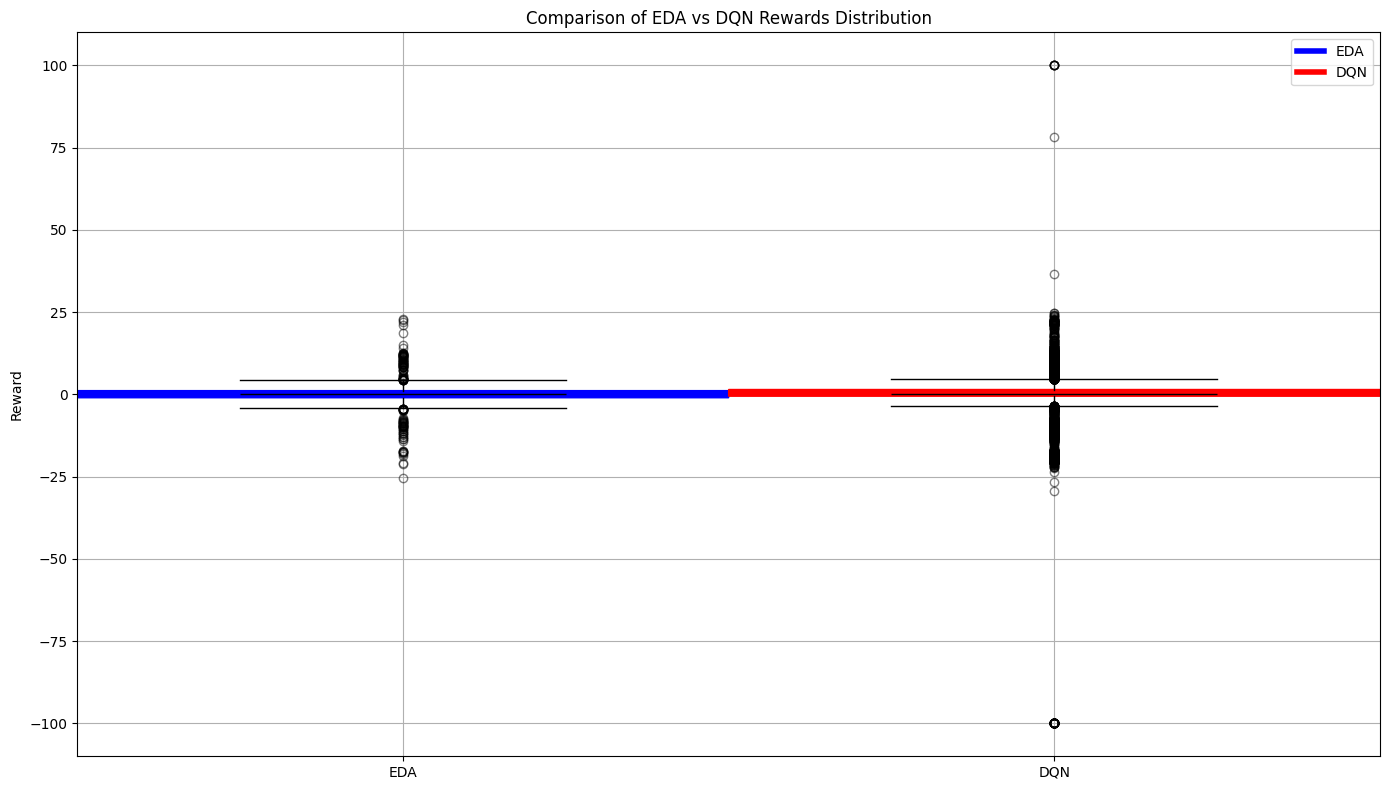

In [ ]:
plot_box_rewards(eda_rewards, dqn_rewards, eda_indices, dqn_indices)

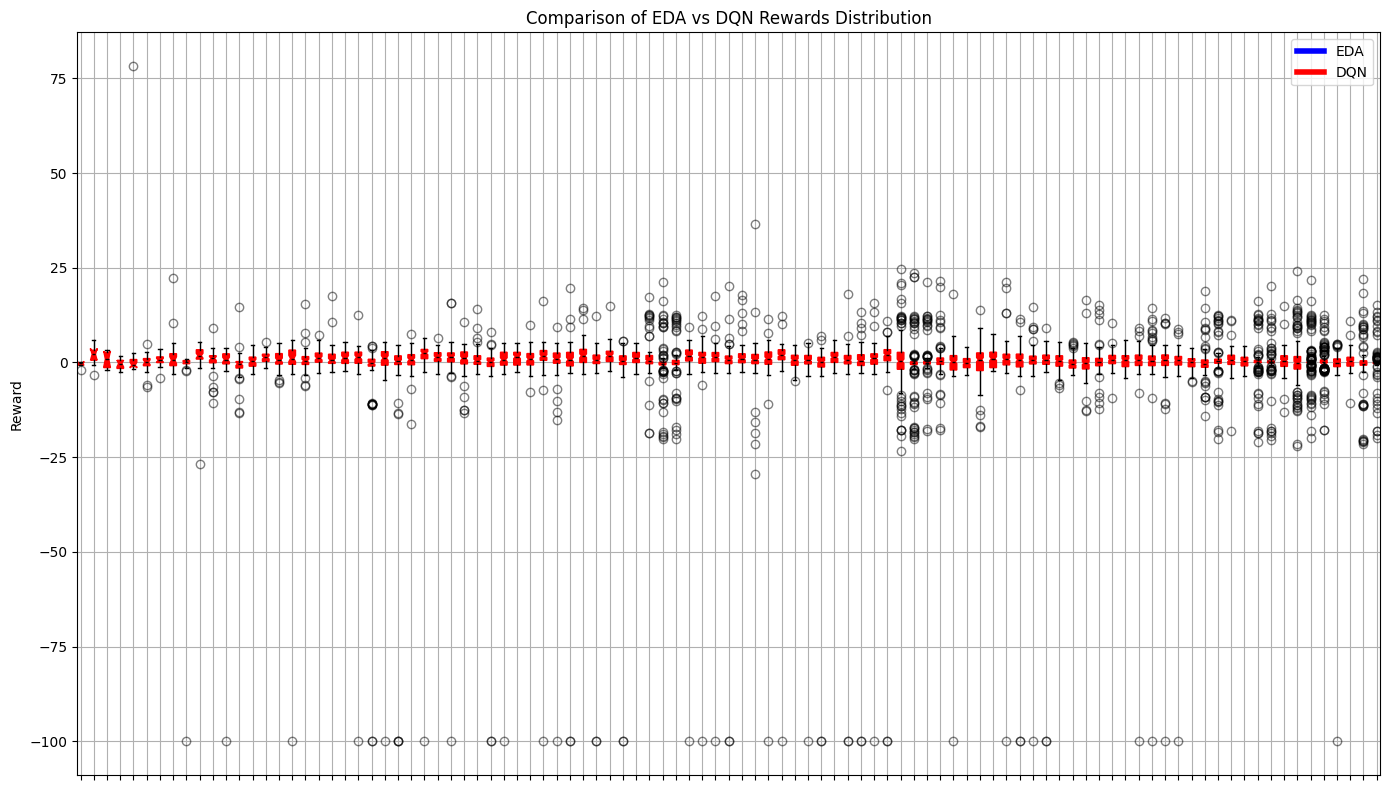

In [ ]:
plot_box_rewards(eda_rewards, dqn_rewards, n_intervals=100, eda_indices= eda_indices, dqn_indices=dqn_indices)

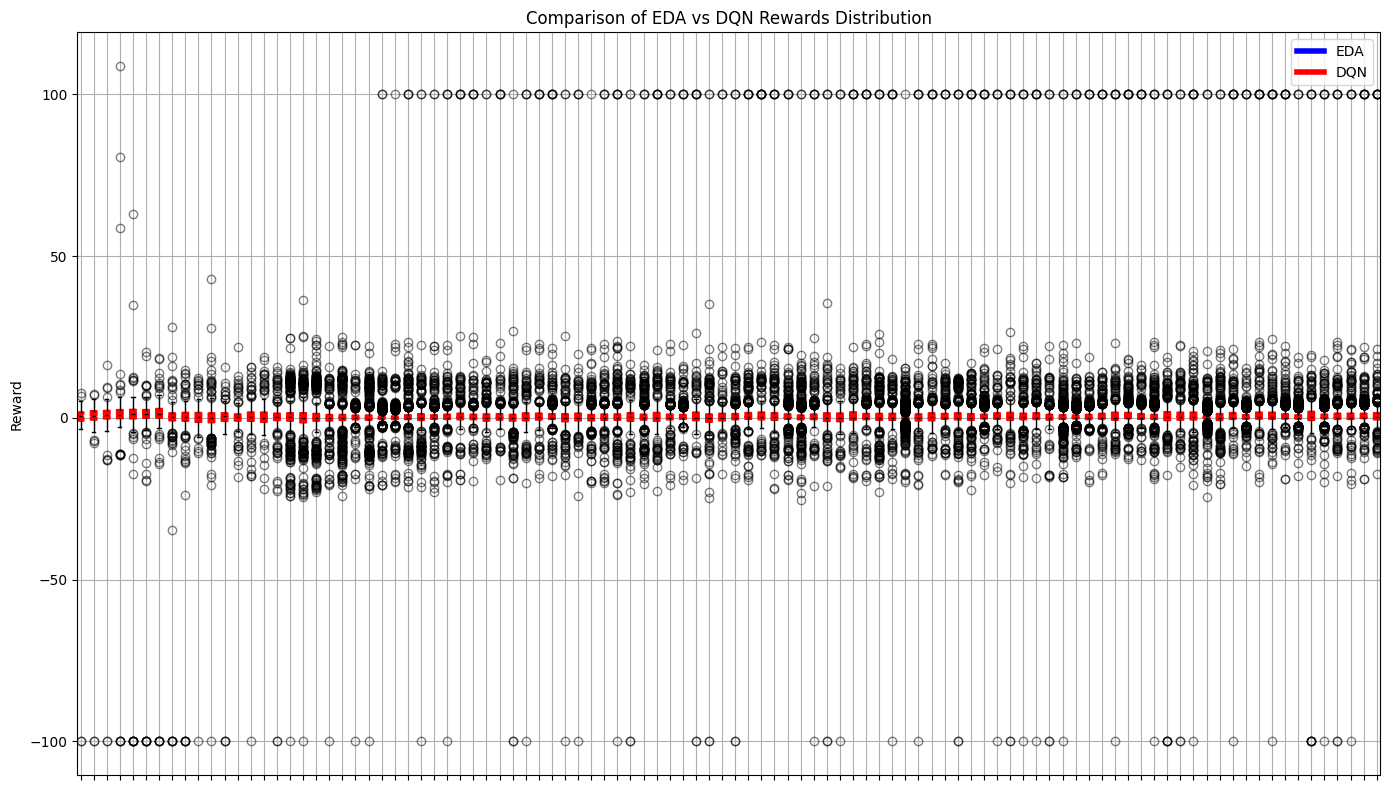

In [ ]:
plot_box_rewards(eda_rewards, dqn_rewards, n_intervals=100, eda_indices= eda_indices, dqn_indices=dqn_indices)

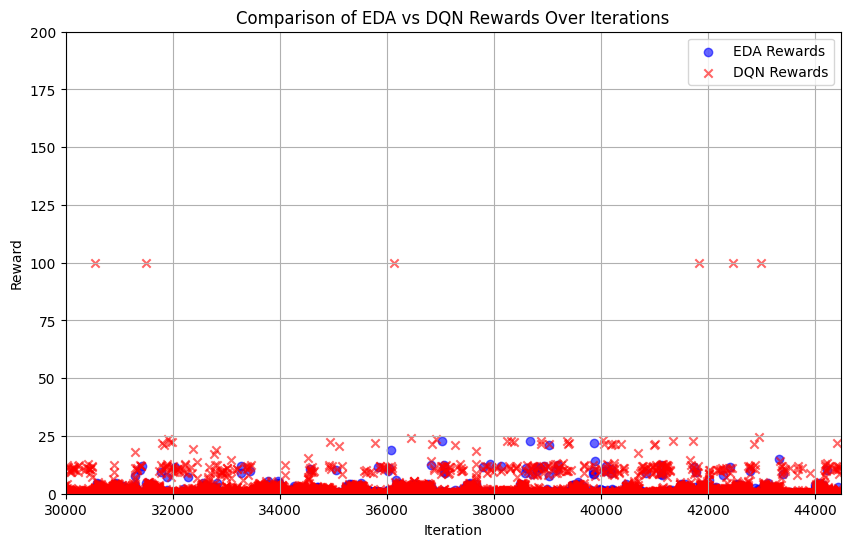

In [ ]:
# Definir los rangos de los ejes, asegúrate de que INITIAL_CLUSTERING_THRESHOLD y agent.memory.current_size están definidos
xaxis_range = [INITIAL_CLUSTERING_THRESHOLD, agent.memory.current_size]

plot_rewards(eda_indices, eda_rewards, dqn_indices, dqn_rewards, xaxis_range, [0, 200])

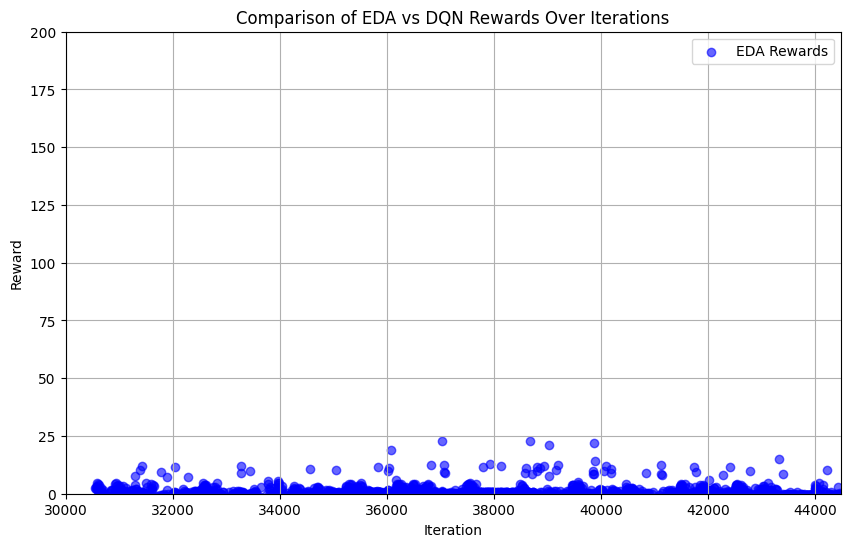

In [ ]:
plot_rewards(eda_indices, eda_rewards, dqn_indices, dqn_rewards, xaxis_range, [0, 200], type_filter="EDA")

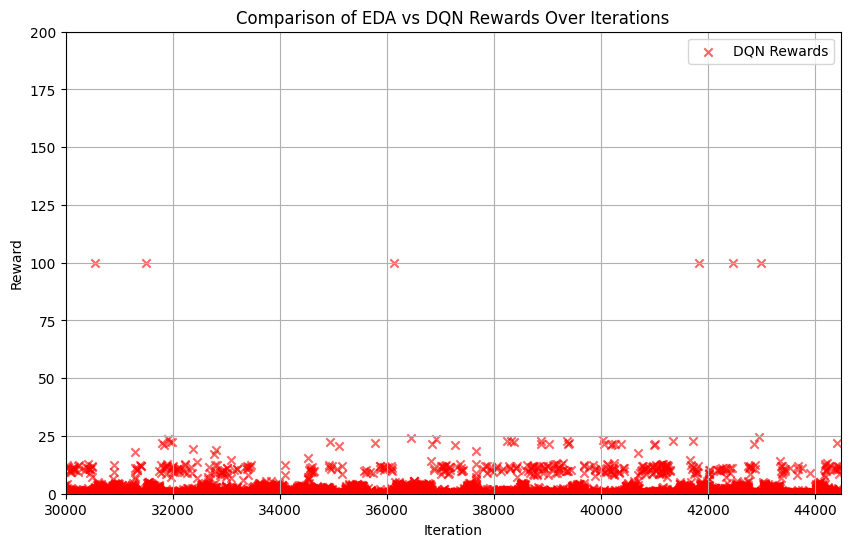

In [ ]:
plot_rewards(eda_indices, eda_rewards, dqn_indices, dqn_rewards, xaxis_range, [0, 200], type_filter="DQN")

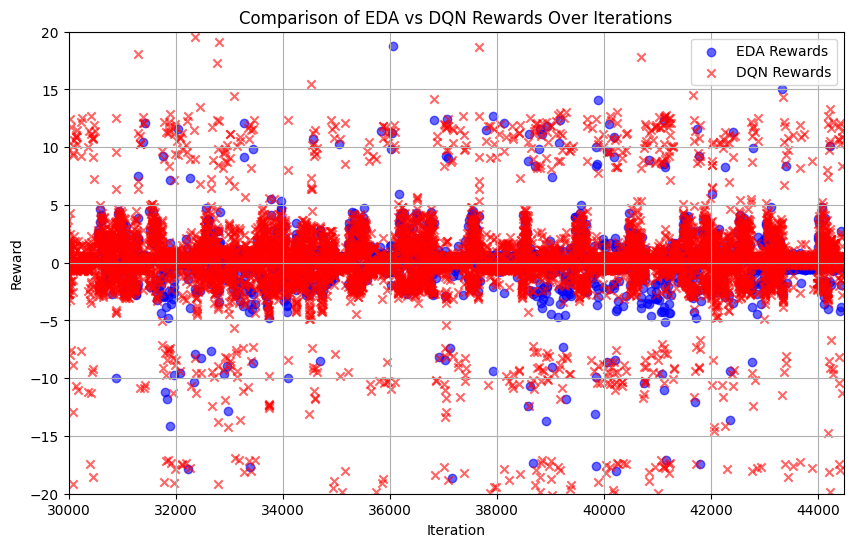

In [ ]:
plot_rewards(eda_indices, eda_rewards, dqn_indices, dqn_rewards, xaxis_range, [-20, 20])

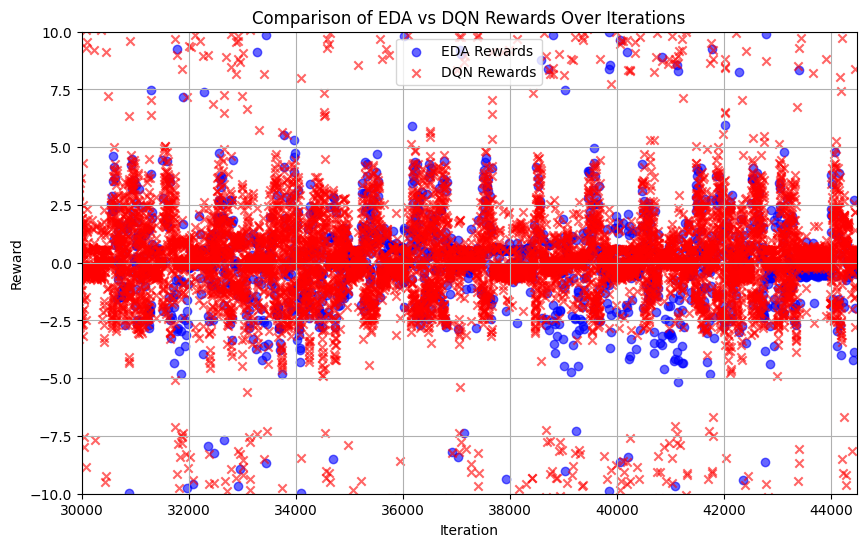

In [ ]:
plot_rewards(eda_indices, eda_rewards, dqn_indices, dqn_rewards, xaxis_range, [-10, 10])

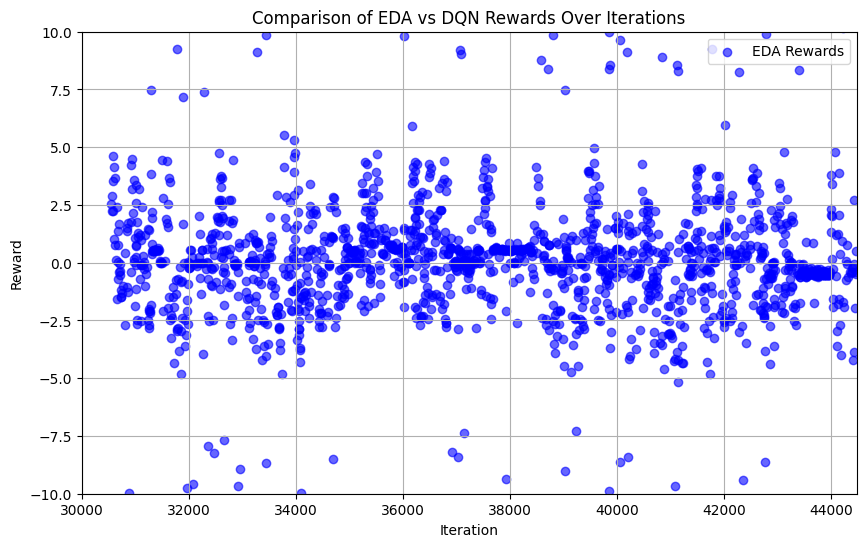

In [ ]:
plot_rewards(eda_indices, eda_rewards, dqn_indices, dqn_rewards, xaxis_range, [-10, 10], type_filter="EDA")

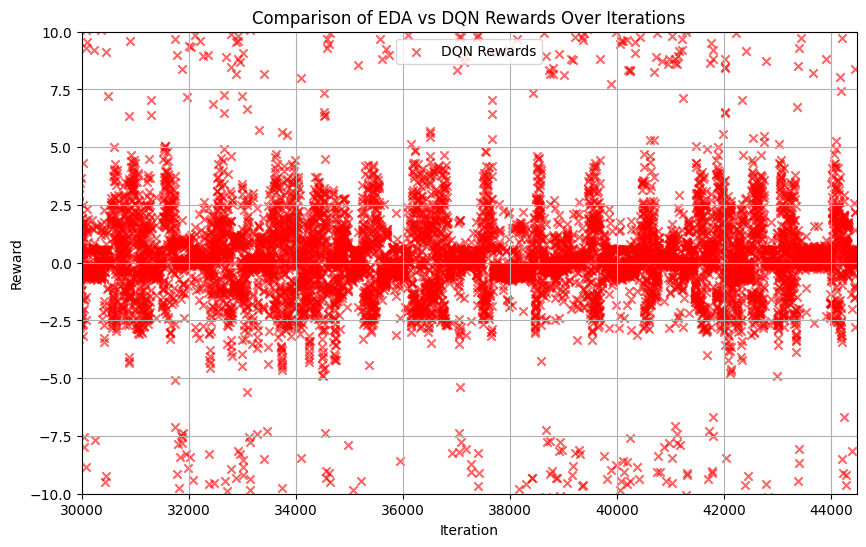

In [ ]:
plot_rewards(eda_indices, eda_rewards, dqn_indices, dqn_rewards, xaxis_range, [-10, 10], type_filter="DQN")

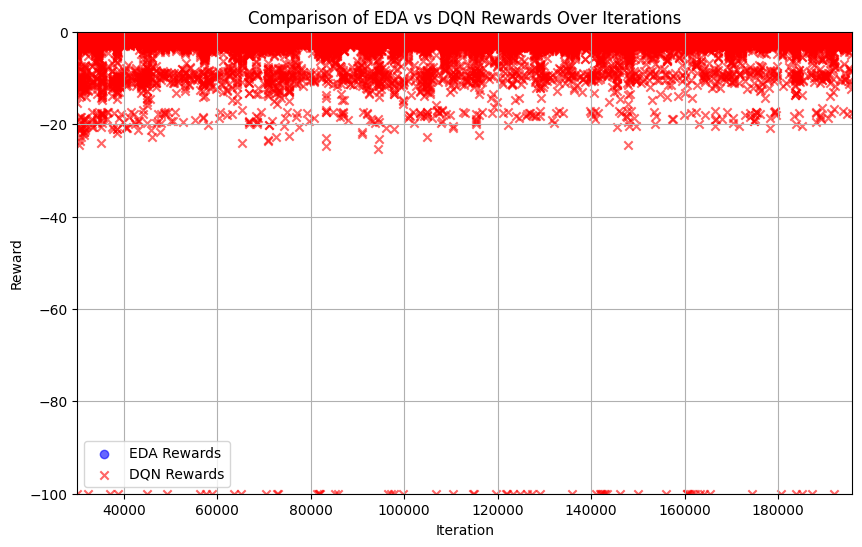

In [ ]:
plot_rewards(eda_indices, eda_rewards, dqn_indices, dqn_rewards, xaxis_range, [-100, 0])

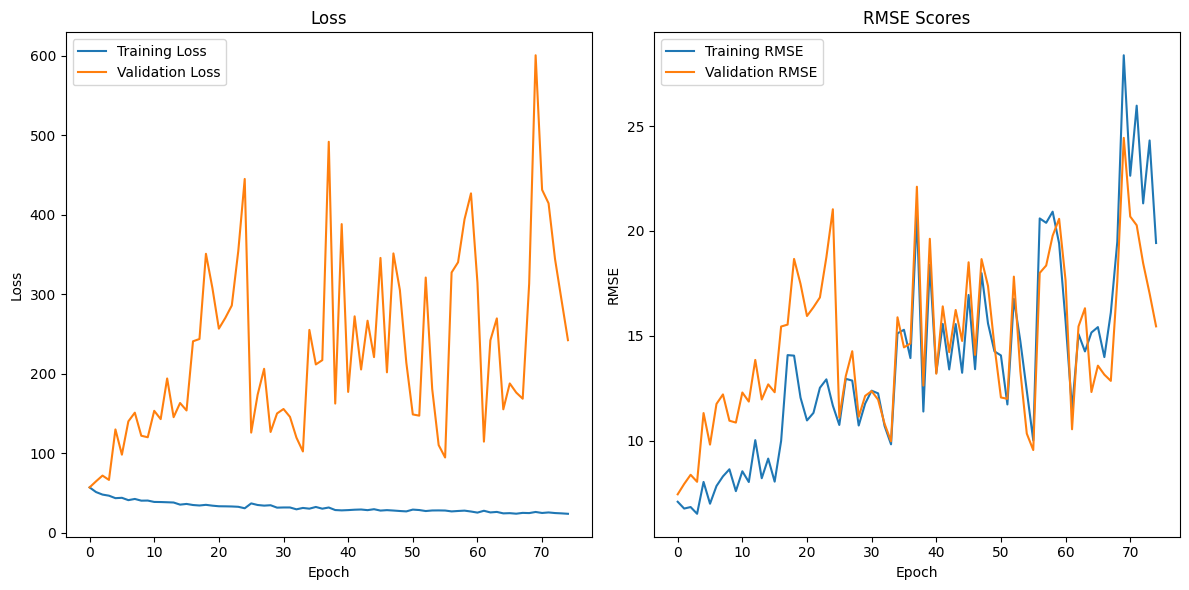

In [ ]:
agent.memory.plot_metrics()

## EDAS

In [ ]:
for n in range(30):
    print(len(agent.memory.filter_transitions_by_cluster(n)["rewards"]))

1905
6
39
4242
1379
24
1725
29
535
511
229
100
240
148
232
5
182
3479
121
9
1768
832
4
39
6174
6
53
9
1855
33


In [ ]:
agent.model.save('modelo_discreto_epsilon4.h5')

c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


states, actions, rewards, states_next, terminal_states, q_values

In [ ]:
mem=agent.memory.sample_memory(64)

In [ ]:
state=mem[0]
qvalue=mem[5]
reward=mem[2]

In [ ]:
res=[]
for i in range(0,64):
    res.append(agent.memory.predict_reward(state[:][i], qvalue[i]))

In [ ]:
diff=[]
for i in range(0, 64):
    diff.append(abs(reward[i]-res[i]))

In [ ]:
len(reward)

64

In [ ]:
agent.memory.predict_reward(state, qvalue)

InvalidArgumentError: Graph execution error:

Detected at node sequential/dense/Relu defined at (most recent call last):
  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\runpy.py", line 196, in _run_module_as_main

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\runpy.py", line 86, in _run_code

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\traitlets\config\application.py", line 1077, in launch_instance

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\tornado\platform\asyncio.py", line 215, in start

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\asyncio\base_events.py", line 603, in run_forever

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\asyncio\base_events.py", line 1909, in _run_once

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\asyncio\events.py", line 80, in _run

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code

  File "C:\Users\victo\AppData\Local\Temp\ipykernel_25392\3826306240.py", line 1, in <module>

  File "C:\Users\victo\AppData\Local\Temp\ipykernel_25392\2983072582.py", line 205, in predict_reward

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\engine\training.py", line 2655, in predict

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\layers\core\dense.py", line 255, in call

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\activations.py", line 306, in relu

  File "c:\Users\victo\anaconda3\envs\reinforcement\lib\site-packages\keras\src\backend.py", line 5395, in relu

Matrix size-incompatible: In[0]: [1,832], In[1]: [13,128]
	 [[{{node sequential/dense/Relu}}]] [Op:__inference_predict_function_35654294]

(Guardamos y cargamos el modelo porque al ejecutar todo el notebook de golpe aparecía un error en el test relacionado con la renderización y requería reiniciar el notebook de nuevo)

In [ ]:
# Ruta del archivo
file_path = 'modelo_discreto_epsilon4.h5'

# Abrir el archivo como un objeto de archivo binario
with h5py.File(file_path, 'r') as f:
    # Cargar el modelo desde el objeto de archivo
    loaded_model = keras.models.load_model(f)

In [ ]:
new_agent = DQN(number_of_observations, number_of_actions)
new_agent.model = loaded_model

In [ ]:
new_agent

### **4.4. Testing Lunar Lander Model** <a class="anchor" id="44"></a>

[Table of Contents](#01)

In [ ]:
# Crear una nueva instancia del agente y actualizar su modelo
new_agent = DQN(number_of_observations, number_of_actions)
new_agent.model = loaded_model

# Proceso de prueba con new_agent
new_agent.delete_scores()
episode = 0
start_time = time.perf_counter()

while episode < NUMBER_OF_EPISODES_FOR_TESTING:
    episode += 1
    score = 0
    raw_state = environment.reset()
    state = raw_state[0] if isinstance(raw_state, tuple) else raw_state
    steps = 0  # Inicializa el contador de pasos por episodio
    end_episode = False

    while not end_episode:
        # Añadir la proporción de pasos realizados al estado
        proportion_of_steps_done = steps / MAX_STEPS_PER_EPISODE
        extended_state = np.append(state, proportion_of_steps_done)

        action = new_agent.select_greedy_policy(extended_state)
        raw_state_next, reward, terminal_state, truncated, info = environment.step(action)
        state_next = raw_state_next[0] if isinstance(raw_state_next, tuple) else raw_state_next

        score += reward
        steps += 1  # Incrementa el contador de pasos

        if terminal_state or truncated or steps >= MAX_STEPS_PER_EPISODE:
            new_agent.add_score(score)
            print(f"Episode {episode:>3}: score {math.trunc(score):>3}")
            end_episode = True
        else:
            state = state_next

print("Time for testing:", round((time.perf_counter() - start_time) / 60), "minutes")
print("Score (average):", np.mean(new_agent.scores))
print("Score (max):", max(new_agent.scores))

environment.close()


Episode   1: score -89
Episode   2: score 113
Episode   3: score -127
Episode   4: score 246
Episode   5: score -41
Episode   6: score 181
Episode   7: score 181
Episode   8: score -123
Episode   9: score 135
Episode  10: score 208
Episode  11: score 259


KeyboardInterrupt: 

### **4.5. Lunar Lander Test Results** <a class="anchor" id="45"></a>

[Table of Contents](#01)

# **5. Conclusions** <a class="anchor" id="5"></a>

[Table of Contents](#01)